## Loading up packages

In [2]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [3]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool

In [4]:
# Define the path to our data files and the path we want to save our outputs in. 
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/mmus/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/mmus/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/mmus/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/mmus/'
save_path2 = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TASEP-KS/mmus/'
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
gtf_name = 'mm10.refGene.gtf'
mutation = 'Fmr1'
samp_num = '1'

# figure out if the notebook has already been done for this dataset and only run the
# visualizations. 
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [5]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

## Loading up the csv file.

In [6]:
# Load in the count positions data.
data_mutant = kat.load_count_positions(mutation+"_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_"+ samp_num +"_counts.csv",csv_path)

In [7]:
# Load in the elongation rates data.
elon_mutant = kat.load_elongation_rates(mutation + '_' + samp_num + 'raw_elongation_rates', elon_path)
elon_control = kat.load_elongation_rates('control' + '_' + samp_num + 'raw_elongation_rates', elon_path)

## Define functions

In [8]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
def get_pbar_from_count(tr_m):
    M = sum(tr_m)
    p = tr_m/M
    x=0
    pbar=[]
    for px in p:
        pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
        pbar.append(pbar_x)
        x = x+1
        if x  == len(p)-9:
            break
    pbar = np.array(pbar)
    return(pbar)

## Calculate Smoothed Vector Arrays

OK, note too self: this time around I really should probably find a way to do this such that the stuff that is going to be filtered out gets filtered out. 
I think those runtime warnings are causing more problems 

There has to be a way to remove all of those genes with no reads. I need to figure out some way to keep their indices the same while removing all that stupid stuff. Also need to check what happens when I perform loess smoothing on 21493. I can almost certainly just do the thing I am doin for the KS-tasep method and I feel dumb now. 

In [9]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    mutant_list = []
    control_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, transcripts):
        if len(tr_m) > 100 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15:
            mutant_list.append(tr_m)
            control_list.append(tr_c)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())

In [10]:
max_pool = 20

# get smoothed vector arrays for all of the control data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_control = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       control_list),
                total=len(control_list)
            )
        )    
# Why do some of these (12430) take so much longer than others? 

In [11]:
# get smoothed vector arrays for all of the mutant data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_mutant = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       mutant_list),
                total=len(mutant_list)
            )
        )    

## Determine KS statistic for all transcripts

In [12]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    len_list = []
    for tr_m, tr_c, index in zip(mutant_list, control_list, list(range(len(mutant_list)))):
        position = np.array(list(range(len(tr_m))))
        smoothed_vec_m, cumul_m = pool_mutant[index]
        smoothed_vec_c, cumul_c = pool_control[index]
        ks = max(abs(cumul_m - cumul_c))
        ks_list.append(ks)
        len_list.append(len(tr_m))
            
    # reorganizing the lists into a dataframe. 
    df_b = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, len_list)))
    df_b.columns = ["gene_ID","transcript_ID", "ks_stat", "gene_length"]
    df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)
    
    # Clear out unneeded lists
    ks_list.clear()
    gene_list.clear()
    tr_id.clear()
    len_list.clear()

In [13]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df_b = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

(0.0, 0.7)

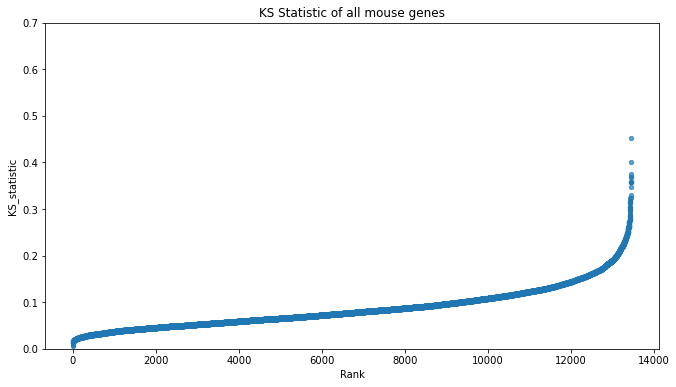

In [14]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), sorted(df_b["ks_stat"]), s=18, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS Statistic of all mouse genes")
plt.ylim(0,0.7)

In [15]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df_b["gene_length"]:
    if i < 700:
        size_groups.append(1)
    elif i >= 700 and i < 1750:
        size_groups.append(2)
    elif i >= 1750:
        size_groups.append(3)
df_b["size_groups"] = size_groups

In [16]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.37)].groupby('gene_ID')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [17]:
len(diff_dist)

3

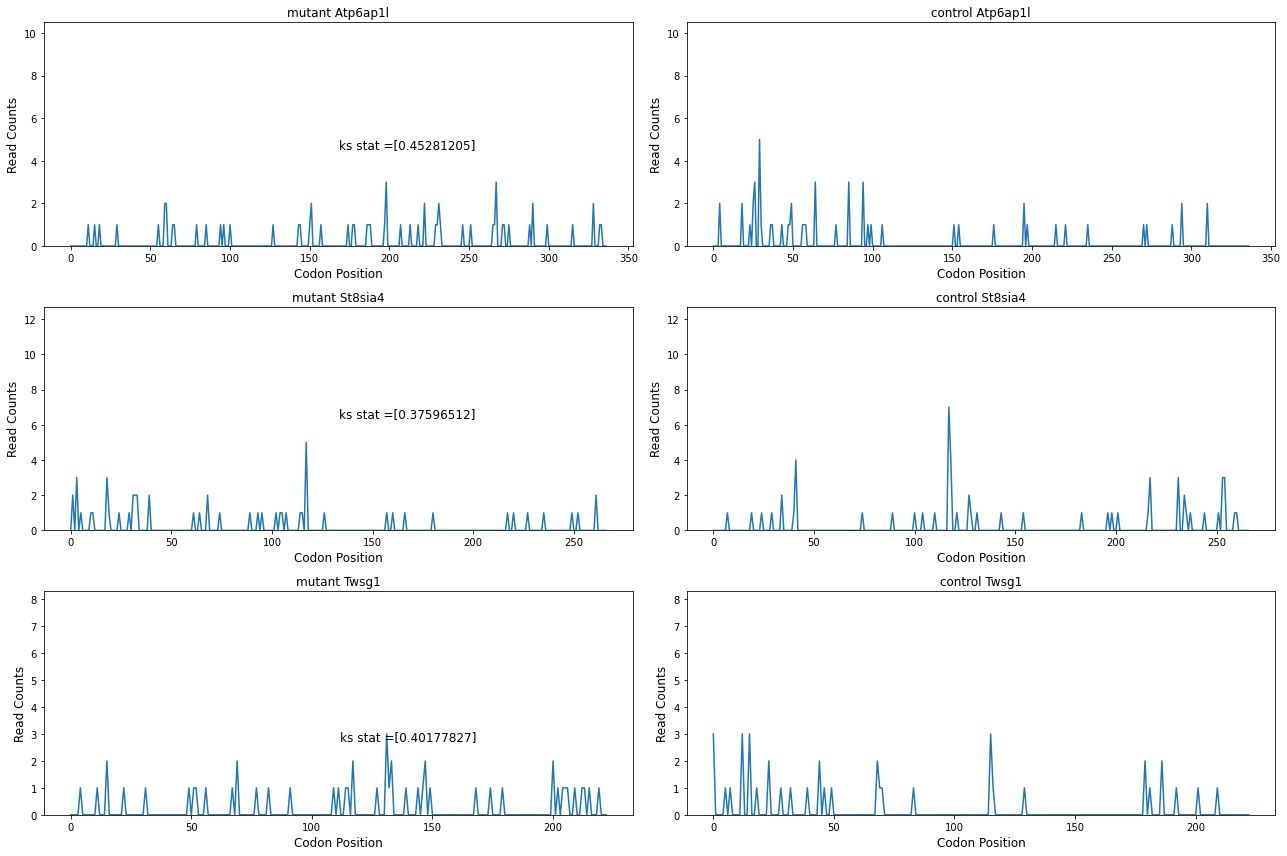

In [18]:
# Look at the smoothed count distributions for each of the transcripts that passed the threshold
ax = kat.big_dif_mmus(diff_dist, transcripts, data_mutant, data_control, figsize = (18,len(diff_dist)*4), fontsize = 12)

## Tasep-KS method

In [19]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    alt_p_list = []
    pbar_m_list = []
    pbar_c_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, el_m, el_c, transcript in zip(data_mutant, data_control, elon_mutant, elon_control, transcripts):
        if len(tr_m) > 100 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15 and sum(el_c) > 0 and sum(el_m) > 0:
            alt_p_list.append(kat.alter_p(el_c, el_m))
            pbar_m_list.append(get_pbar_from_count(tr_m))
            pbar_c_list.append(get_pbar_from_count(tr_c))
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())

In [20]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_alt_p = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       alt_p_list),
                total=len(alt_p_list)
            )
        )    

In [21]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_pbar_m = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       pbar_m_list),
                total=len(pbar_m_list)
            )
        )    

In [22]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_pbar_c = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       pbar_c_list),
                total=len(pbar_c_list)
            )
        )    

In [23]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_m_list = []
    ks_c_list = []
    ks_diff_list = []
    for pbar_m, pbar_c, alt_p in zip(pool_pbar_m, pool_pbar_c, pool_alt_p):
        sm_m, cumul_m = pbar_m
        sm_c, cumul_c = pbar_c
        sm_p, cumul_p = alt_p
        for d, i in zip(sm_m, list(range(len(sm_m)))):
            if d < 0:
                 sm_m[i] = 0.000000000000000000001
        ks_m = max(abs(cumul_p - cumul_m))
        ks_c = max(abs(cumul_p - cumul_c))
        ks_diff = ks_c - ks_m
        ks_m_list.append(ks_m)
        ks_c_list.append(ks_c)
        ks_diff_list.append(ks_diff)
            
    # reorganizing the lists into a dataframe. 
    df_t = pd.DataFrame(list(zip(gene_list, tr_id, ks_m_list, ks_c_list, ks_diff_list)))
    df_t.columns = ["gene_ID","transcript_ID", "ks_mutant", "ks_control", "ks_diff"]
    df_t.to_csv(save_path2 + "TASEP_ks_table_" + samp_num + ".csv", index=False)
    
    # Clear out unneeded lists
    ks_m_list.clear()
    ks_c_list.clear()
    ks_diff_list.clear()

In [24]:
if pre_load == True:
    df_t = pd.read_csv(save_path2 + "TASEP_ks_table_" + samp_num + ".csv")

Text(0.5, 1.0, 'KS difference (control - mutant)')

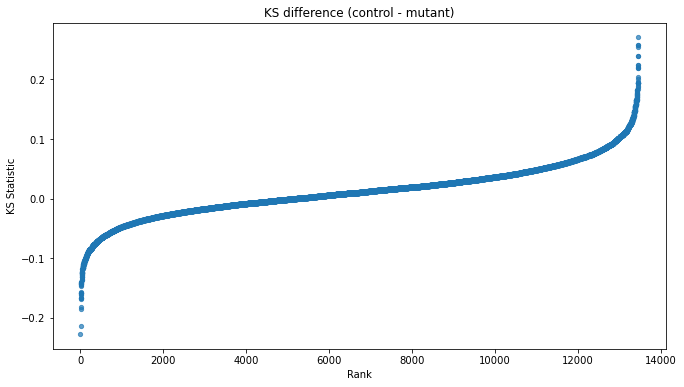

In [25]:
figure(figsize = (11,6))
plt.scatter(list(range(len(df_t["ks_diff"]))), sorted(df_t["ks_diff"]), s=18, alpha = 0.7)
plt.ylabel("KS Statistic")
plt.xlabel("Rank")
plt.title("KS difference (control - mutant)")

In [26]:
group = df_t[(df_t['ks_diff'] > 0.24)].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['ks_diff'].unique())

In [27]:
len(diff_dist)

5

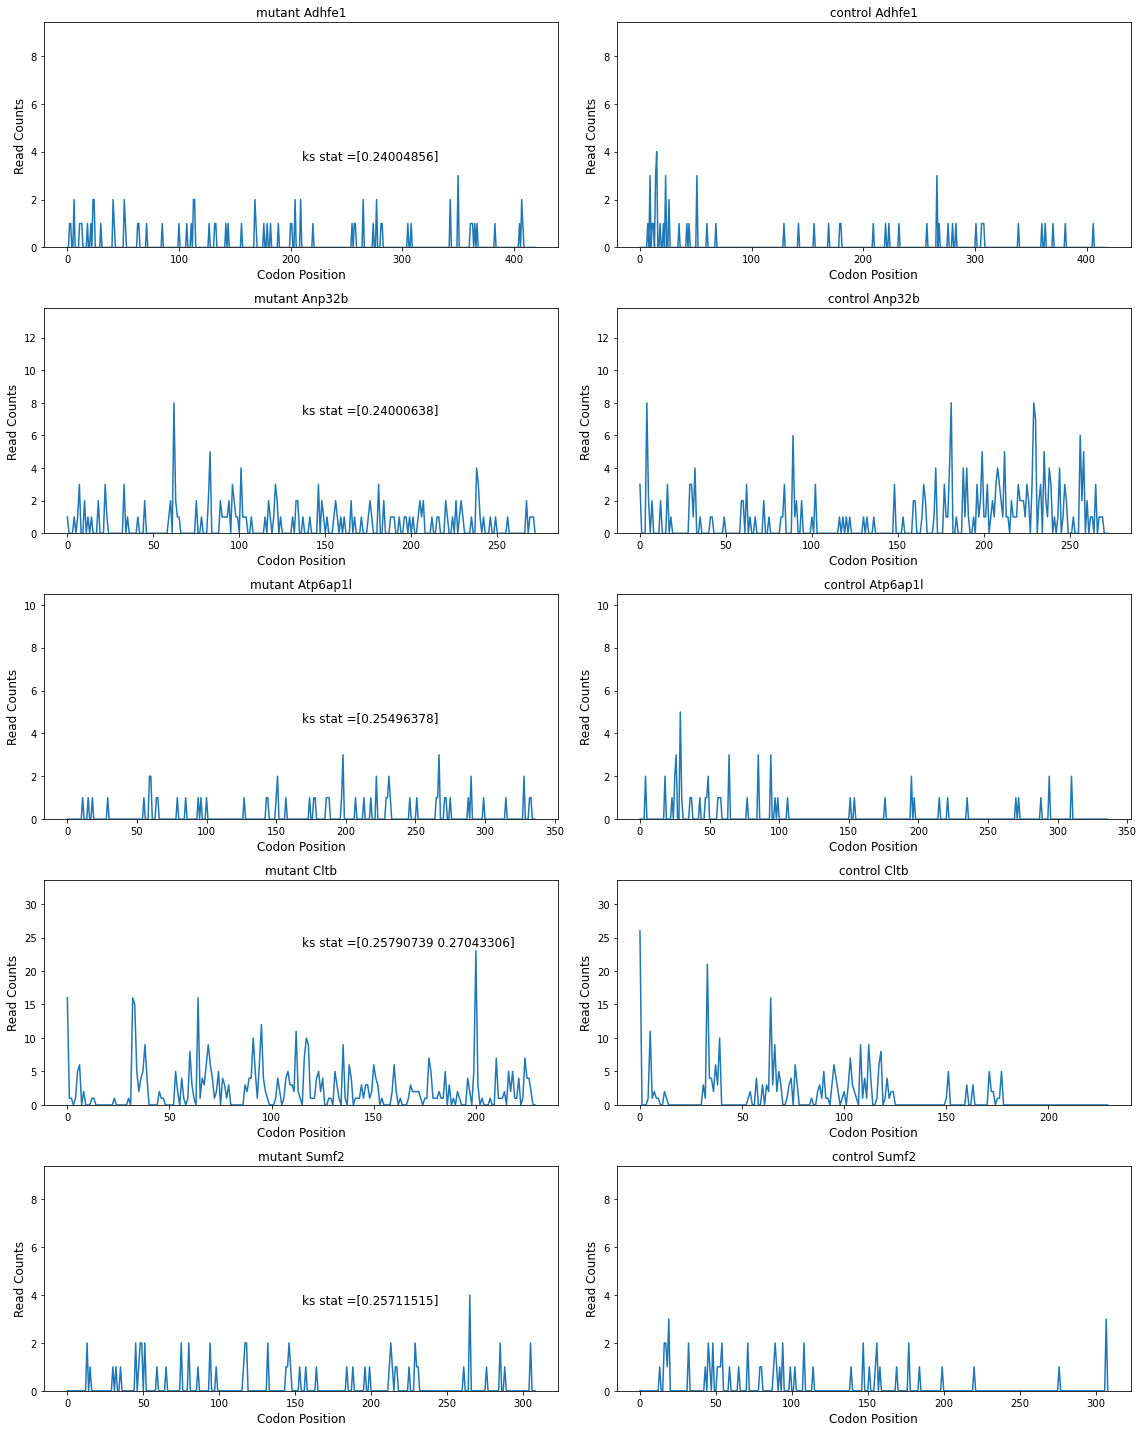

In [28]:
ax = kat.big_dif_mmus(diff_dist, transcripts, data_mutant, data_control, figsize = (16,len(diff_dist)*4), fontsize = 12)

## Choose the gene of interest and smooth out the array.

In [41]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_gene = 'Auts2'
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_trans_mmus(my_gene, 
                                           transcripts, data_mutant, data_control)

In [42]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [43]:
sum(my_vec_control)

278

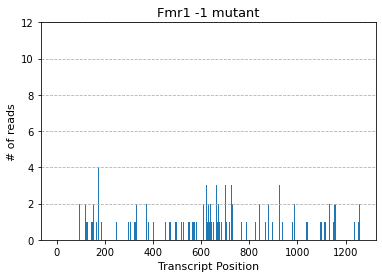

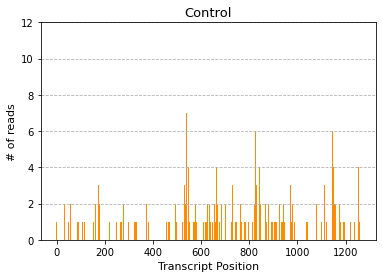

In [44]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])
plt.bar(list(range(len(my_vec_mutant))),my_vec_mutant, width = 2.8)
plt.ylim([0,maxi+5])
plt.title("Fmr1 -1 mutant", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.ylabel("# of reads", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.savefig(image_path + my_gene + '_mutant_array.pdf')
plt.show()
plt.bar(list(range(len(my_vec_control))),my_vec_control, width = 2.8, color = "darkorange")
plt.ylim([0,maxi+5])
plt.title("Control", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.ylabel("# of reads", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.savefig(image_path + my_gene + '_control_array.pdf')

In [45]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_vec_control+0.00000000001)

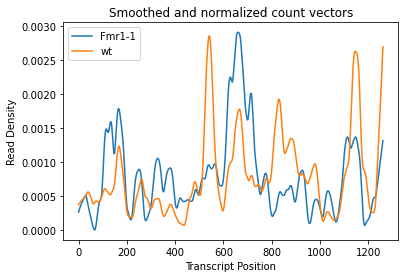

In [46]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

In [63]:
ks = max(abs(cumul_m - cumul_c))
ks

0.04655313016425916

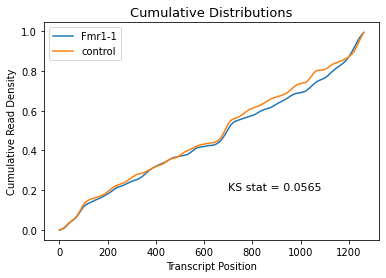

In [40]:
plt.plot(my_position, cumul_m, label = "Fmr1-1")
plt.plot(my_position, cumul_c, label = "control")
plt.text(700, 0.2, "KS stat = "+ str(round(ks, 4)), fontsize = 11)
plt.ylabel("Cumulative Read Density")
plt.xlabel("Transcript Position")
plt.title("Cumulative Distributions", fontsize = 13)
plt.legend()
plt.savefig(image_path + my_gene + '_cumulative.pdf')